<a href="https://colab.research.google.com/github/sgparrot/sgparrot2021Lv1-1/blob/main/Simpsons/simpson_preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import time
import glob
import zipfile

import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import albumentations as A
import matplotlib.pyplot as plt

from tensorflow.keras.utils import to_categorical, Sequence

from pprint import pprint
from datetime import datetime
from sklearn.model_selection import train_test_split

%matplotlib inline

# 데이터 불러오기

In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
target=os.listdir("/content/drive/MyDrive/parrot/simpson/simpsons_dataset/train")
target.sort()

In [ ]:
category={}
for i, name in enumerate(target):
  category[i]=name

pprint(category)

{0: 'bart',
 1: 'charles_montgomery',
 2: 'krusty',
 3: 'lisa_simpson',
 4: 'marge_simpson',
 5: 'milhouse_van_houten',
 6: 'moe_szyslak',
 7: 'ned_flanders',
 8: 'principal_skinner'}


In [ ]:
train_data=np.load("/content/drive/MyDrive/parrot/simpson/train_224_npz.npz")
test_data=np.load("/content/drive/MyDrive/parrot/simpson/test_224_npz.npz")

In [ ]:
X_train=train_data['X_train_npz']
y_train=train_data['y_train_npz']

y_train=to_categorical(y_train, len(target))

X_test=test_data['X_test_npz']
y_test_list=pd.read_csv("/content/drive/MyDrive/parrot/simpson/test_sample.csv", index_col=0)
y_test=np.array(y_test_list['files'])

In [ ]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(11248, 224, 224, 3) (11248, 9) (1086, 224, 224, 3) (1086,)


# train test split

In [ ]:
train_data, val_data, train_labels, val_labels = train_test_split(X_train, y_train, test_size=0.2)

# augmentation

In [ ]:
train_batch_size = 64
test_batch_size = 64
image_size = 224

In [ ]:
# train data augmentor
augmentor_train = A.Compose([
                             A.HorizontalFlip(p=0.5),
                             A.ShiftScaleRotate(p=0.75),
                             A.RandomBrightnessContrast(
                                 brightness_limit=(-0.25, 0.25),
                                 contrast_limit=(-0.25, 0.25), p=1
                                 ),   # 밝기와 대비 조절
                             A.CLAHE(p=1),   # Contrast-Limited Adaptive Histogram Equalization
                             A.OneOf([A.MotionBlur(p=1),   # Blur
                                      A.OpticalDistortion(p=1),   # 왜곡
                                      A.GaussNoise(p=1)], p=0.5),   # Noise
                             A.Cutout(num_holes = 32, max_h_size=4,
                                      max_w_size=4, p=0.75),   # dropout
                             A.Normalize(mean=(0, 0, 0), std=(1, 1, 1))
])

# test data augmentor
augmentor_test = A.Compose([A.Normalize(mean=(0, 0, 0), std=(1, 1, 1))])

# Dataloader

In [ ]:
class Dataloader(Sequence): # Sequence 상속 받는 클래스 정의

    def __init__(self, x_set, y_set, batch_size,
                 augmentor= None, shuffle=False):   # augmentor가 추가됨

        """
        x_set, y_set: train set or test set (np.ndarray)
        batch_size: the size of data when a batch is enumerated (int)
        augmentor: data augmentor (albumantation, imgaug, ...)
        shuffle: whether shuffle the data or not after each epoch (boolean)
        """

        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.augmentor = augmentor
        self.shuffle=shuffle
        self.on_epoch_end()

    def __len__(self):  #전체 길이, #data/batch_size
        return int(np.ceil(len(self.x) / self.batch_size))

    def __getitem__(self, idx): #batch index 값에 따라 데이터 반환
        indices = self.indices[idx*self.batch_size: (idx+1)*self.batch_size]

        batch_x = [self.x[i] for i in indices]
        batch_y = [self.y[i] for i in indices]

        for image_index in range(indices.shape[0]):

            image = batch_x[image_index]

            if self.augmentor is not None:
                image = self.augmentor(image=image)["image"]

            batch_x[image_index] = image
        
        return np.array(batch_x), np.array(batch_y)
    
    ### Epoch이 한 번 끝날 때마다 shuffle
    def on_epoch_end(self):
        self.indices = np.arange(len(self.x))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

In [ ]:
train_loader = Dataloader(train_data, train_labels, batch_size=train_batch_size,
                          augmentor=augmentor_train, shuffle=True)
val_loader = Dataloader(val_data, val_labels, batch_size=train_batch_size,
                        augmentor=augmentor_train, shuffle=True)
test_loader = Dataloader(X_test, y_test, batch_size=test_batch_size,
                         augmentor=augmentor_test, shuffle=False)

In [ ]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_target) = next(examples)

print("Data  : {}".format(example_data.shape))
print("Target: {}".format(example_target.shape))

Data  : (64, 224, 224, 3)
Target: (64, 9)


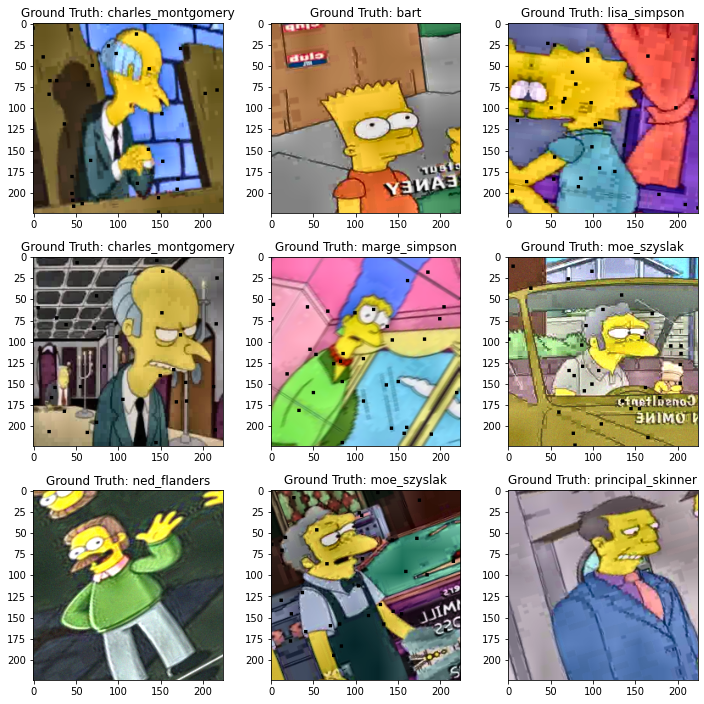

In [ ]:
fig = plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, 1 + i)
    plt.tight_layout()
    plt.imshow(example_data[i])
    target = np.where(example_target[i]==1)[0]
    plt.title("Ground Truth: {}".format(category.get(int(target))))

plt.show()

In [ ]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_target) = next(examples)

print("Target: {}".format(example_target.shape))
print("Data  : {}".format(example_data.shape))

Target: (64,)
Data  : (64, 224, 224, 3)


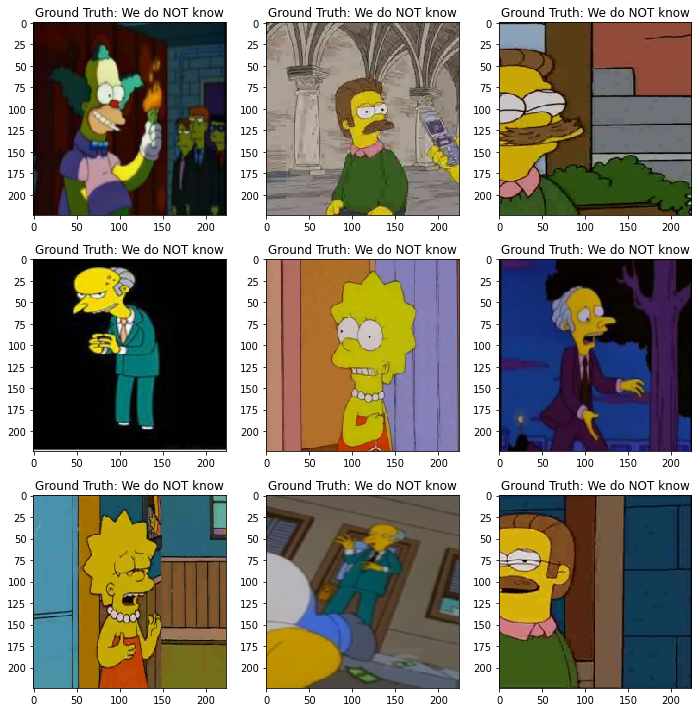

In [ ]:
fig = plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, 1 + i)
    plt.tight_layout()
    plt.imshow(tf.squeeze(example_data[i]), cmap="rainbow", interpolation="none")
    target = np.where(example_target[i]==1)[0]
    plt.title("Ground Truth: {}".format("We do NOT know"))

plt.show()